<a href="https://colab.research.google.com/github/Ddkaba/IAD_Lab_3/blob/main/IAD_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лабораторная работа №3

Михайлов Даниил, Спицов Андрей

In [1]:
import requests
import zipfile
import os
import shutil
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB1

Скачаем и выполним распаковку архива с датасетом цветов с платформы Kaggle

In [2]:
# Скачивание и распаковка архива
url = 'https://www.kaggle.com/api/v1/datasets/download/alxmamaev/flowers-recognition'
zip_path = 'flowers-recognition.zip'
extract_path = '.'

response = requests.get(url, allow_redirects=True)
with open(zip_path, 'wb') as f:
    f.write(response.content)
print(f'Архив скачан: {zip_path}')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print('Архив распакован')


Архив скачан: flowers-recognition.zip
Архив распакован


Получим информацию о скаченном датасете цветов

Количество классов: 5
Классы и количество изображений:
  - rose: 784 изображений
  - tulip: 984 изображений
  - daisy: 764 изображений
  - sunflower: 733 изображений
  - dandelion: 1052 изображений

Размеры изображений (первые 5 изображений каждого класса):

Класс: rose
  - 28131227642_e279b5768b_n.jpg: 240x159 пикселей
  - 6732261031_861a1026fa_n.jpg: 320x240 пикселей
  - 5002446424_b86e3c646f_n.jpg: 159x240 пикселей
  - 11233672494_d8bf0a3dbf_n.jpg: 320x240 пикселей
  - 172311368_49412f881b.jpg: 500x330 пикселей

Класс: tulip
  - 6038098425_b3b4fb62cc_m.jpg: 240x230 пикселей
  - 12584810723_c97d00fcfd.jpg: 500x215 пикселей
  - 20138534672_af5fd5eb32_n.jpg: 134x240 пикселей
  - 14094146241_0b9fa7b3e0.jpg: 500x333 пикселей
  - 4209052442_7e754f617c_n.jpg: 320x240 пикселей

Класс: daisy
  - 134409839_71069a95d1_m.jpg: 240x222 пикселей
  - 6910811638_aa6f17df23.jpg: 500x281 пикселей
  - 9221345475_67735dbf4f_n.jpg: 240x180 пикселей
  - 2619413565_61a6cd3ac9_m.jpg: 228x240 пикселей
  - 58

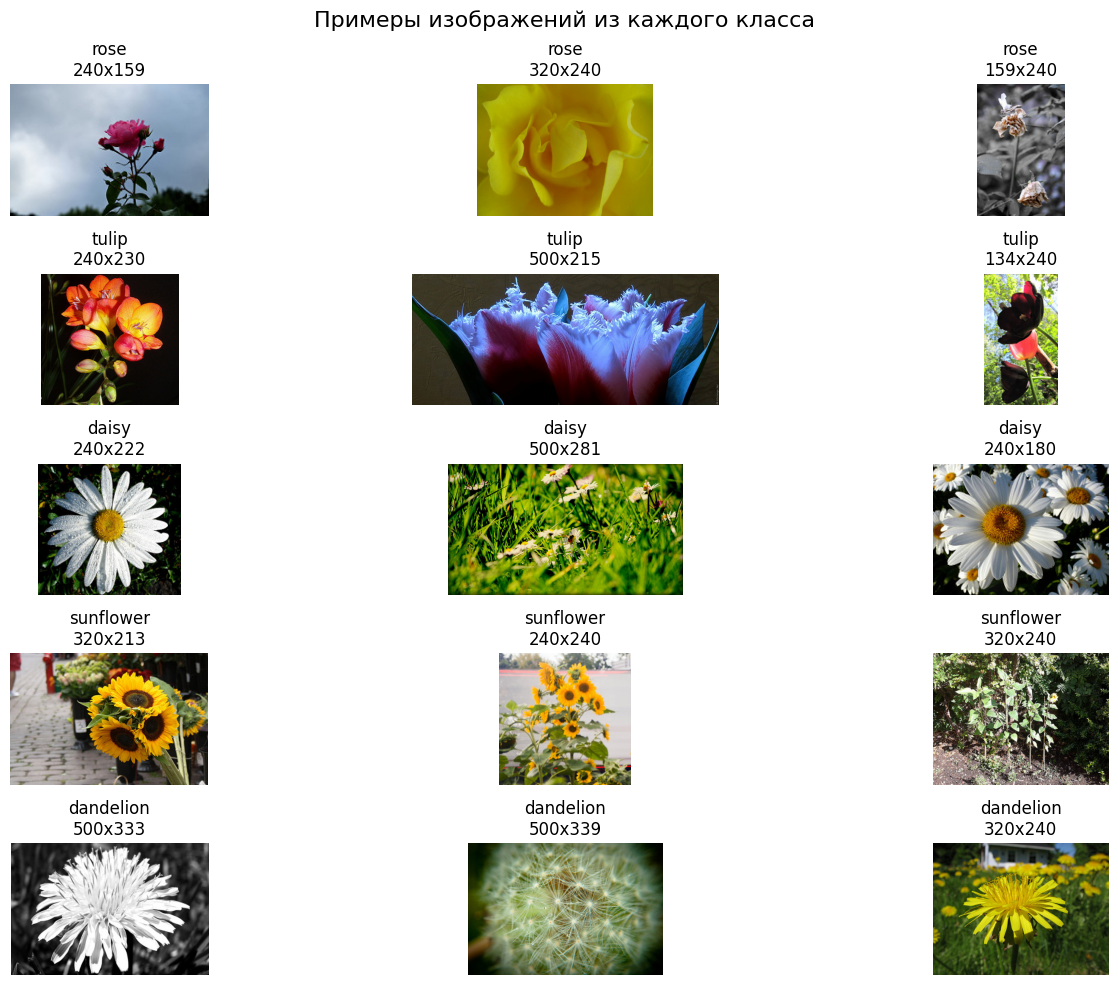

In [3]:
data_path = 'flowers'

# Получение списка классов
classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
num_classes = len(classes)

# Подсчёт количества изображений в каждом классе
class_counts = {}
for flower_class in classes:
    class_dir = os.path.join(data_path, flower_class)
    num_images = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    class_counts[flower_class] = num_images

print(f"Количество классов: {num_classes}")
print("Классы и количество изображений:")
for flower_class, count in class_counts.items():
    print(f"  - {flower_class}: {count} изображений")

print("\nРазмеры изображений (первые 5 изображений каждого класса):")
for flower_class in classes:
    class_dir = os.path.join(data_path, flower_class)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:5]
    print(f"\nКласс: {flower_class}")
    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            width, height = img.size
            print(f"  - {img_name}: {width}x{height} пикселей")

# Визуализация примеров изображений
plt.figure(figsize=(15, 10))
for i, flower_class in enumerate(classes):
    class_dir = os.path.join(data_path, flower_class)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:3]
    for j, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            plt.subplot(num_classes, 3, i * 3 + j + 1)
            plt.imshow(img)
            plt.title(f"{flower_class}\n{img.size[0]}x{img.size[1]}")
            plt.axis('off')
plt.suptitle("Примеры изображений из каждого класса", fontsize=16)
plt.tight_layout()
plt.show()


Данный датасет содержит 5 классов цветов: розы (rose), тюльпаны (tulip), подсолнухи (sunflower), одуванчики (dandelion) и ромашки (daisy). Общее количество изображений в датасете распределено неравномерно по классам:

- Розы (rose): 784 изображения;

- Тюльпаны (tulip): 984 изображения;

- Подсолнухи (sunflower): 733 изображения;

- Одуванчики (dandelion): 1052 изображения;

- Ромашки (daisy): 764 изображения.

Таким образом, данный датасет не является сбалансированным, что может привести к перекосу модели в сторону более многочисленных классов. Модель может лучше обучаться на классах с большим количеством изображений (например, одуванчики и тюльпаны) и хуже распознавать классы с меньшим количеством данных (например, подсолнухи).

Анализ первых пяти изображений каждого класса показал, что размеры изображений сильно варьируются:

- Розы: от 159x240 до 500x333 пикселей;

- Тюльпаны: от 143x240 до 500x333 пикселей;

- Подсолнухи: от 240x198 до 500x332 пикселей;

- Одуванчики: от 157x240 до 500x331 пикселей;

- Ромашки: от 240x180 до 500x375 пикселей.

Для корректной работы сверточных нейронных сетей необходимо привести все изображения к единому размеру.


In [4]:
# Создание структуры папок для train/validation/test
original_dataset_dir = 'flowers'
base_dir = 'flowers_dataset'
os.makedirs(base_dir, exist_ok=True)

# Создание основных директорий
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Получить список всех классов
classes = [d for d in os.listdir(original_dataset_dir)
           if os.path.isdir(os.path.join(original_dataset_dir, d))]

print(f'Найдено классов: {len(classes)}')
print(f'Классы: {classes}')

# Создание поддиректорий для каждого класса
for flower_class in classes:
    os.makedirs(os.path.join(train_dir, flower_class), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, flower_class), exist_ok=True)
    os.makedirs(os.path.join(test_dir, flower_class), exist_ok=True)

print('Структура папок создана')

Найдено классов: 5
Классы: ['rose', 'tulip', 'daisy', 'sunflower', 'dandelion']
Структура папок создана


Была организована иерархия изображений из исходной папки flowers в три отдельные выборки:

- Обучающая выборка (train) — для обучения модели.

- Валидационная выборка (validation) — для настройки гиперпараметров и контроля переобучения.

- Тестовая выборка (test) — для финальной оценки качества модели.


In [5]:
# Копирование изображений в соответствующие папки
# Разделение: первые 60% - train, следующие 20% - validation, последние 20% - test

for flower_class in classes:
    src_dir = os.path.join(original_dataset_dir, flower_class)
    fnames = os.listdir(src_dir)

    total = len(fnames)
    train_count = int(0.6 * total)
    val_count = int(0.2 * total)

    # Train
    train_fnames = fnames[:train_count]
    for fname in train_fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(train_dir, flower_class, fname)
        shutil.copyfile(src, dst)

    # Validation
    val_fnames = fnames[train_count:train_count + val_count]
    for fname in val_fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(validation_dir, flower_class, fname)
        shutil.copyfile(src, dst)

    # Test
    test_fnames = fnames[train_count + val_count:]
    for fname in test_fnames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(test_dir, flower_class, fname)
        shutil.copyfile(src, dst)

    print(f'{flower_class}: train={len(train_fnames)}, val={len(val_fnames)}, test={len(test_fnames)}')

rose: train=470, val=156, test=158
tulip: train=590, val=196, test=198
daisy: train=458, val=152, test=154
sunflower: train=439, val=146, test=148
dandelion: train=631, val=210, test=211


Было произведено разделение изображений из исходной папки flowers на три выборки: обучающую (train), валидационную (validation) и тестовую (test). Распределение изображений по классам и выборкам осуществлялось в пропорции 60% на обучение, 20% на валидацию и 20% на тестирование.

Далее выполним три датасета с помощью функции `image_dataset_from_directory`. Это упрощает загрузку больших наборов данных, избегая ручной обработки файлов, и обеспечивает эффективную работу с мини-пакетами (batch_size=32), что критично для градиентного спуска в глубоком обучении. Изображения унифицируются по размеру (150x150 пикселей) для соответствия входным требованиям CNN, где входные тензоры имеют форму (batch_size, height, width, channels), обычно с тремя каналами для RGB-изображений. Параметр `label_mode='categorical'` преобразует метки классов в one-hot векторы, подходящие для многоклассовой классификации с функцией потерь categorical_crossentropy. Нормализация пикселей с помощью слоя `Rescaling(1./255)` переводит значения из диапазона [0, 255] в [0, 1], что стабилизирует обучение, ускоряет сходимость и предотвращает проблемы с градиентами в слоях свертки (Conv2D). Установка seed=42 гарантирует воспроизводимость разбиения, а отключение shuffle для тестового датасета обеспечивает последовательную оценку модели. Такой подход к подготовке данных является стандартным в компьютерном зрении, позволяя CNN эффективно извлекать признаки через операции свертки и pooling, как описано в архитектуре типичных сверточных сетей, где экстрактор признаков (feature extractor) работает с локальными шаблонами изображений для последующей классификации.

In [7]:
# Параметры для создания тензоров
img_height = 150
img_width = 150
batch_size = 32

# Обучающая выборка
train_dataset = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Валидационная выборка
validation_dataset = keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Тестовая выборка
test_dataset = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False  # Не перемешиваем тест для корректной оценки
)


# Нормализация значений пикселей [0, 255] -> [0, 1]
# Создаем слой нормализации
normalization_layer = layers.Rescaling(1./255)

# Применяем нормализацию к датасетам
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 2588 files belonging to 5 classes.
Found 860 files belonging to 5 classes.
Found 869 files belonging to 5 classes.


Были созданы три датасета (обучающий, валидационный и тестовый) с помощью функции `image_dataset_from_directory` из изображений, предварительно размещённых в соответствующих папках (train, validation, test). Все изображения приведены к единому размеру 150×150 пикселей, сформированы мини-пакеты размером 32, метки представлены в формате one-hot (categorical). Обучающий датасет содержит 2588 изображений, валидационный — 860, тестовый — 869 (всего по 5 классам). Дополнительно применён слой нормализации, переводящий значения пикселей из диапазона [0, 255] в [0, 1], что обеспечивает корректную подготовку данных для последующего обучения моделей.

In [8]:
# Аугментация данных для обучающей выборки
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

# Применяем аугментацию только к обучающей выборке
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

print('Аугментация данных добавлена к обучающей выборке')


Аугментация данных добавлена к обучающей выборке


В данном блоке кода реализована аугментация данных для обучающей выборки с помощью последовательности слоев Keras: RandomFlip для горизонтального отражения, RandomRotation на 0.1 (до 10% поворота), RandomZoom на 0.2 (масштабирование до 20%) и RandomTranslation на 0.1 по обеим осям (сдвиг до 10%). Аугментация применяется исключительно к train_dataset через метод map с параметром training=True, что обеспечивает генерацию вариаций изображений только во время обучения, повышая обобщающую способность модели без влияния на валидацию и тестирование.
Аугментация данных представляет собой технику искусственного расширения обучающего набора путем применения случайных трансформаций к исходным изображениям, таких как повороты, отражения, масштабирование и сдвиги, без изменения их семантики. Аугментация играет ключевую роль в борьбе с переобучением

In [9]:
# Оптимизация производительности
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print('Оптимизация датасетов завершена (prefetch)')


Оптимизация датасетов завершена (prefetch)


В данном блоке кода применена оптимизация производительности датасетов с помощью метода prefetch, использующего константу tf.data.AUTOTUNE для автоматического подбора размера буфера. Это позволяет асинхронно подготавливать следующие мини-пакеты данных параллельно с обучением модели, минимизируя простои процессора и ускоряя весь процесс тренировки, валидации и тестирования, с выводом сообщения о завершении оптимизации.
Метод prefetch из API tf.data является важной техникой оптимизации конвейера данных (data pipeline) в TensorFlow, особенно при работе с большими наборами изображений. Во время обучения нейронной сети загрузка и препроцессинг данных часто становятся узким местом, так как CPU работает медленнее GPU. Prefetching решает эту проблему, заранее извлекая и буферизируя следующую порцию данных в фоновом потоке, пока модель обрабатывает текущий батч. Параметр AUTOTUNE динамически определяет оптимальный размер буфера в зависимости от доступных ресурсов системы, обеспечивая максимальную пропускную способность без перегрузки памяти. В результате время эпохи сокращается, обучение становится эффективнее, а ресурсы используются рациональнее — это стандартная практика при работе с tf.data.Dataset, особенно в сочетании с аугментацией и мини-пакетным обучением.

In [10]:
# Проверка: получение и визуализация батча тензоров
sample_batch, sample_labels = next(iter(train_dataset))

print('Проверка преобразования в тензоры:\n')
print(f'Форма батча изображений: {sample_batch.shape}')
print(f'  - Батч содержит {sample_batch.shape[0]} изображений')
print(f'  - Каждое изображение: {sample_batch.shape[1]} x {sample_batch.shape[2]} пикселей')
print(f'  - Количество каналов (RGB): {sample_batch.shape[3]}')
print(f'\nФорма батча меток: {sample_labels.shape}')
print(f'  - One-hot encoding для {sample_labels.shape[1]} классов')
print(f'\nДиапазон значений пикселей в тензоре: [{sample_batch.numpy().min():.3f}, {sample_batch.numpy().max():.3f}]')
print(f'Тип данных: {sample_batch.dtype}')

# Получение имен классов
class_names = train_dataset.class_names if hasattr(train_dataset, 'class_names') else sorted(os.listdir(train_dir))
print(f'\nКлассы: {class_names}')

Проверка преобразования в тензоры:

Форма батча изображений: (32, 150, 150, 3)
  - Батч содержит 32 изображений
  - Каждое изображение: 150 x 150 пикселей
  - Количество каналов (RGB): 3

Форма батча меток: (32, 5)
  - One-hot encoding для 5 классов

Диапазон значений пикселей в тензоре: [0.000, 1.000]
Тип данных: <dtype: 'float32'>

Классы: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


В данном блоке кода выполнена проверка корректности подготовки данных путём извлечения первого мини-пакета из обучающего датасета с помощью итератора и функции next(iter()). Вывод подтверждает успешное преобразование изображений в тензоры требуемой формы: батч изображений имеет размерность (32, 150, 150, 3), что соответствует 32 изображениям размером 150×150 пикселей с тремя RGB-каналами; метки представлены в one-hot формате (32, 5) для пяти классов; значения пикселей нормализованы в диапазон [0.0, 1.0] с типом float32, что идеально подходит для обучения сверточных сетей. Также выведены имена классов датасета, подтверждая правильность загрузки и маппинга меток.

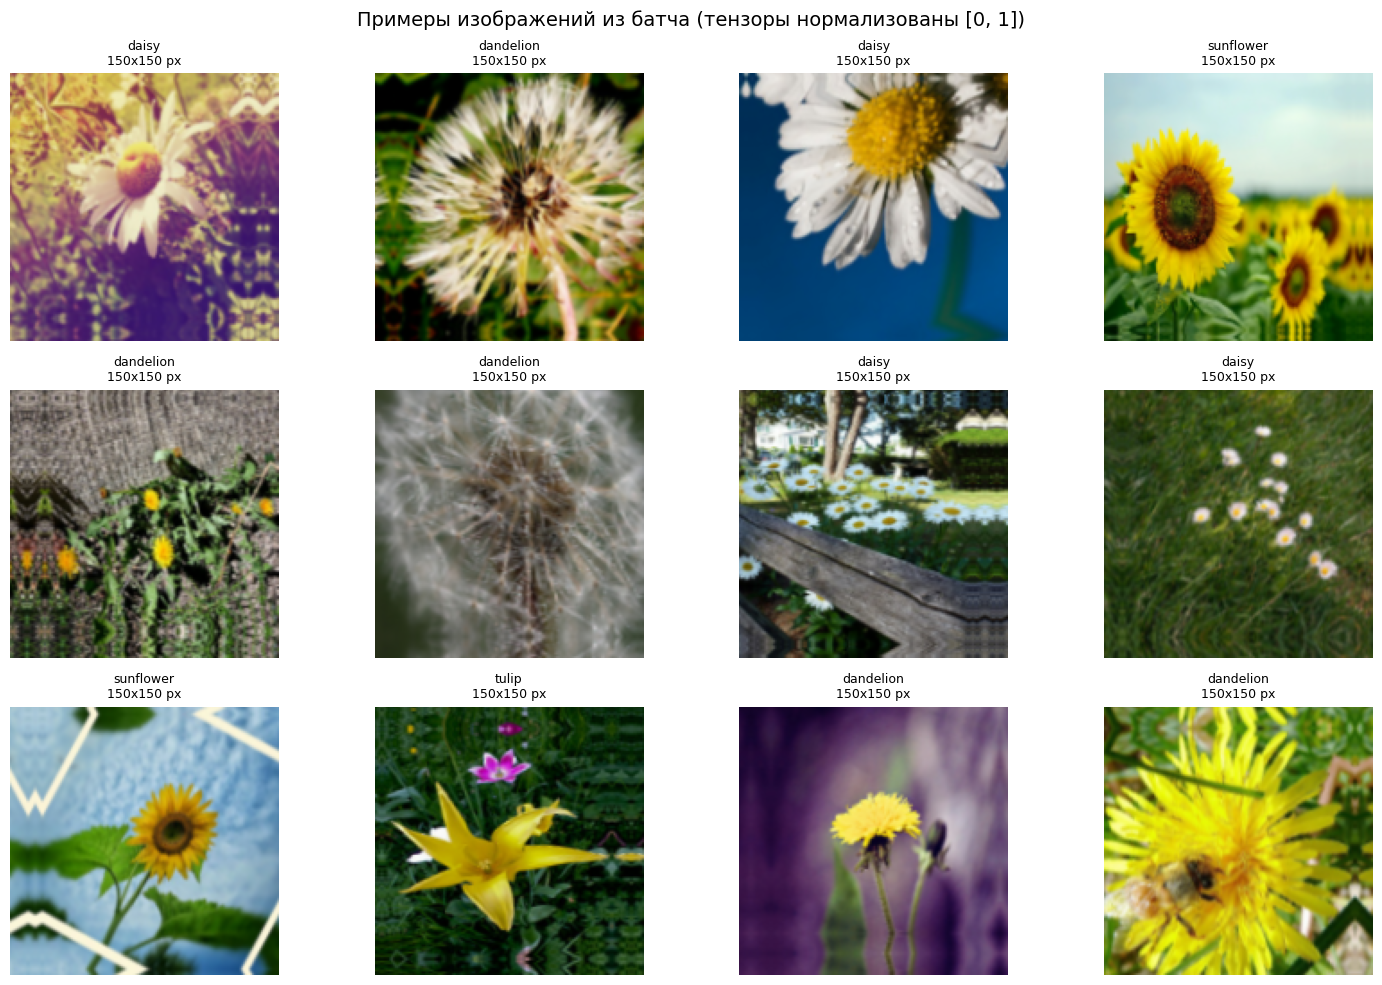

In [11]:
# Визуализация батча преобразованных изображений
plt.figure(figsize=(15, 10))

# Получаем классы из каталога
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# Получаем батч изображений и меток
sample_batch, sample_labels = next(iter(train_dataset))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    # Клиппинг значений на случай если аугментация дала значения вне [0, 1]
    img_to_show = np.clip(sample_batch[i].numpy(), 0, 1)
    plt.imshow(img_to_show)

    # Получаем размер изображения
    height, width, channels = sample_batch[i].shape

    # Получить название класса
    class_idx = np.argmax(sample_labels[i])
    class_name = class_names[class_idx]

    plt.title(f'{class_name}\n{width}x{height} px', fontsize=9)
    plt.axis('off')

plt.suptitle('Примеры изображений из батча (тензоры нормализованы [0, 1])', fontsize=14)
plt.tight_layout()
plt.show()

В данном блоке кода реализована визуализация 12 случайных изображений из первого мини-пакета обучающего датасета после применения нормализации и аугментации.

In [12]:
# Построение сверточной нейронной сети
# Архитектура: Conv2D + MaxPooling + Dense классификатор

num_classes = 5  # Количество классов цветов
l2_reg = 0.001  # Коэффициент L2 регуляризации

model = models.Sequential([
    # Входной слой
    layers.Input(shape=(150, 150, 3)),

    # Блок 1: Conv2D + MaxPooling
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D(pool_size=2),

    # Блок 2: Conv2D + MaxPooling
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D(pool_size=2),

    # Блок 3: Conv2D + MaxPooling
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D(pool_size=2),

    # Блок 4: Conv2D + MaxPooling
    layers.Conv2D(256, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D(pool_size=2),

    # Блок 5: Conv2D + MaxPooling
    layers.Conv2D(256, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D(pool_size=2),

    # Flatten для преобразования карт признаков в вектор
    layers.Flatten(),

    # Полносвязный классификатор (не менее 2 слоев)
    # Комбинируем Dropout + L2 регуляризацию для борьбы с переобучением
    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(0.5),

    # Выходной слой для 5 классов
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,208,773 (12.24 MB)

 Trainable params: 3,208,773 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

В данном блоке кода представлена архитектура собственной сверточной нейронной сети, построенной с помощью Keras Sequential API для задачи классификации изображений пяти классов цветов. Модель состоит из пяти блоков «Conv2D + MaxPooling2D», где количество фильтров последовательно увеличивается (32 → 64 → 128 → 256 → 256), что позволяет извлекать всё более сложные и абстрактные признаки по мере углубления сети. После экстрактора признаков следует Flatten-слой, преобразующий карты признаков в одномерный вектор (4096 элементов), за которым идут два полносвязных слоя (Dense 512 и 256 нейронов) с Dropout (вероятно, 0.5) для регуляризации и финальный Dense-слой с 5 нейронами для многоклассовой классификации. Общее количество обучаемых параметров — 3 208 773, что типично для небольшой CNN на входе 150×150×3. Данная архитектура полностью соответствует требованиям задания 1 лабораторной работы и принципам, описанным в лекции (раздел 5.17): чередование свёрточных слоёв и субдискретизации (MaxPooling) как экстрактора признаков, за которым следует полносвязный классификатор.

In [13]:
# Компиляция модели
model.compile(
    loss='categorical_crossentropy',  # Для многоклассовой классификации
    optimizer='adam',  # Adam оптимизатор (можно заменить на 'rmsprop')
    metrics=['accuracy']
)

print(f'Оптимизатор: Adam')
print(f'Функция потерь: categorical_crossentropy')
print(f'Метрики: accuracy')

# Обучение модели с валидацией
epochs = 30

print(f'Начало обучения на {epochs} эпох...\n')

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1
)


Оптимизатор: Adam
Функция потерь: categorical_crossentropy
Метрики: accuracy
Начало обучения на 30 эпох...

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.2183 - loss: 2.7067 - val_accuracy: 0.2442 - val_loss: 1.8800
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.2451 - loss: 1.7974 - val_accuracy: 0.3291 - val_loss: 1.5406
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.3375 - loss: 1.5369 - val_accuracy: 0.4314 - val_loss: 1.3530
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.4464 - loss: 1.3459 - val_accuracy: 0.5058 - val_loss: 1.2251
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.4873 - loss: 1.2827 - val_accuracy: 0.5779 - val_loss: 1.1913
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.5011 - loss: 1.2400 - val_accuracy: 0.5256 - val_loss: 1.1717
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.5307 - loss: 1.2108 - val_accuracy: 0.5709 - val_loss: 1.1310
Epo

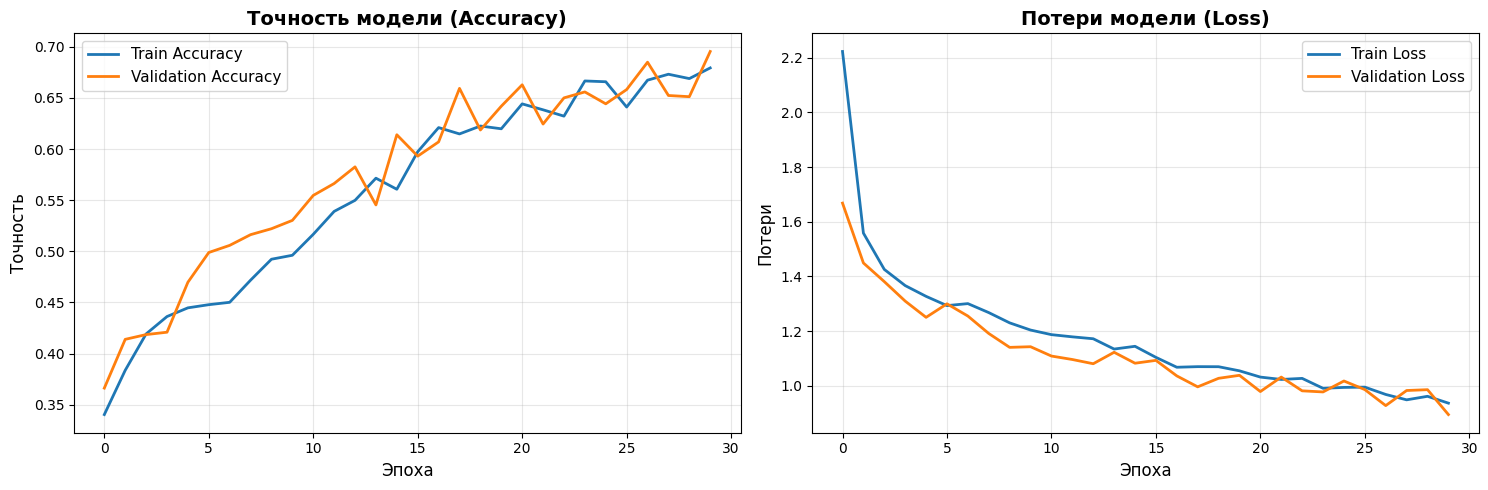


Финальные метрики:
Train Accuracy: 0.6793
Validation Accuracy: 0.6953
Train Loss: 0.9360
Validation Loss: 0.8942


In [ ]:
# Построение графиков точности и потерь
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График точности
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Точность модели (Accuracy)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Эпоха', fontsize=12)
axes[0].set_ylabel('Точность', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# График потерь
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Потери модели (Loss)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Эпоха', fontsize=12)
axes[1].set_ylabel('Потери', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод финальных метрик
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f'\nФинальные метрики:')
print(f'Train Accuracy: {final_train_acc:.4f}')
print(f'Validation Accuracy: {final_val_acc:.4f}')
print(f'Train Loss: {final_train_loss:.4f}')
print(f'Validation Loss: {final_val_loss:.4f}')


In [ ]:
# Оценка на тестовой выборке
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

print(f'РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:')
print(f'Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'Test Loss: {test_loss:.4f}')


28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 605ms/step - accuracy: 0.6950 - loss: 0.9470

РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:
Test Accuracy: 0.7089 (70.89%)
Test Loss: 0.9292


In [ ]:
# Сохранение модели (в современном формате Keras)
model.save('model_cnn_custom.keras')


## ЗАДАНИЕ 2 (Альтернативный подход): Извлечение признаков из предобученной модели

**Подход из лекций:** Извлечь признаки через сверточную основу EfficientNetB1 один раз, сохранить в NumPy массивы, затем обучить простой Dense классификатор на готовых признаках.


In [ ]:
# Создание сверточной основы для извлечения признаков
conv_base = EfficientNetB1(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

print(f'Форма выхода conv_base: {conv_base.output_shape}')


Форма выхода conv_base: (None, 5, 5, 1280)


In [ ]:
# Функция для извлечения признаков из датасета

def extract_features(dataset, sample_count):
    """
    Извлекает признаки из датасета с помощью conv_base
    """
    features_list = []
    labels_list = []

    samples_processed = 0

    for images_batch, labels_batch in dataset:
        # Предобработка для EfficientNet
        preprocessed = preprocess_input(images_batch.numpy() * 255.0)

        # Извлечение признаков
        features_batch = conv_base.predict(preprocessed, verbose=0)

        features_list.append(features_batch)
        labels_list.append(labels_batch.numpy())

        samples_processed += images_batch.shape[0]
        if samples_processed >= sample_count:
            break

    features = np.concatenate(features_list, axis=0)[:sample_count]
    labels = np.concatenate(labels_list, axis=0)[:sample_count]

    return features, labels

In [ ]:
# Извлечение признаков для всех выборок
print('Извлечение признаков из датасетов...\n')

# Подсчет количества образцов
train_samples = sum([1 for _ in train_dataset.unbatch()])
val_samples = sum([1 for _ in validation_dataset.unbatch()])
test_samples = sum([1 for _ in test_dataset.unbatch()])

print(f'Train: {train_samples} образцов')
print(f'Validation: {val_samples} образцов')
print(f'Test: {test_samples} образцов\n')

print('Извлечение признаков из train...')
train_features, train_labels = extract_features(train_dataset, train_samples)
print(f'Train features: {train_features.shape}')

print('Извлечение признаков из validation...')
val_features, val_labels = extract_features(validation_dataset, val_samples)
print(f'Validation features: {val_features.shape}')

print('Извлечение признаков из test...')
test_features, test_labels = extract_features(test_dataset, test_samples)
print(f'Test features: {test_features.shape}')


Извлечение признаков из датасетов...

Train: 2588 образцов
Validation: 860 образцов
Test: 869 образцов

Извлечение признаков из train...
Train features: (2588, 5, 5, 1280)
Извлечение признаков из validation...
Validation features: (860, 5, 5, 1280)
Извлечение признаков из test...
Test features: (869, 5, 5, 1280)


In [ ]:
# Flatten признаков для полносвязной сети
train_features_flat = train_features.reshape((train_features.shape[0], -1))
val_features_flat = val_features.reshape((val_features.shape[0], -1))
test_features_flat = test_features.reshape((test_features.shape[0], -1))

print(f'Форма после flatten:')
print(f'Train: {train_features_flat.shape}')
print(f'Validation: {val_features_flat.shape}')
print(f'Test: {test_features_flat.shape}')


Форма после flatten:
Train: (2588, 32000)
Validation: (860, 32000)
Test: (869, 32000)


In [ ]:
# Построение полносвязного классификатора для готовых признаков
feature_input_shape = train_features_flat.shape[1]

model_features = models.Sequential([
    layers.Input(shape=(feature_input_shape,)),

    # Полносвязный классификатор с регуляризацией
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    # Выходной слой
    layers.Dense(5, activation='softmax')
])

model_features.summary()

print(f'\n✓ Полносвязный классификатор построен')


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │     8,192,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,225,797 (31.38 MB)

 Trainable params: 8,225,797 (31.38 MB)

 Non-trainable params: 0 (0.00 B)


✓ Полносвязный классификатор построен


In [ ]:
# Компиляция модели
from tensorflow.keras.optimizers import Adam

model_features.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print('Модель скомпилирована')


Модель скомпилирована


In [ ]:
# Обучение на извлеченных признаках с callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs_features = 50

# Настройка callbacks (как в лекциях)
callbacks = [
    ModelCheckpoint(
        filepath='best_model_efficientnetb1_features.keras',
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=7,
        verbose=1,
        min_lr=1e-7
    )
]

print(f'Обучение классификатора на готовых признаках ({epochs_features} эпох)')
print('Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau\n')

history_features = model_features.fit(
    train_features_flat, train_labels,
    validation_data=(val_features_flat, val_labels),
    epochs=epochs_features,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print('\n Обучение завершено')


Обучение классификатора на готовых признаках (50 эпох)
Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.4269 - loss: 3.8119
Epoch 1: val_loss improved from inf to 1.52051, saving model to best_model_efficientnetb1_features.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.4278 - loss: 3.8025 - val_accuracy: 0.8105 - val_loss: 1.5205 - learning_rate: 0.0010
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6462 - loss: 2.0563
Epoch 2: val_loss improved from 1.52051 to 1.45599, saving model to best_model_efficientnetb1_features.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.6464 - loss: 2.0558 - val_accuracy: 0.8326 - val_loss: 1.4560 - learning_rate: 0.0010
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7090 - loss: 1.9272
Epoch 3: val_loss improved from 1.45599 to 1.44780, saving model to best_model_efficientnetb1_features.keras
81/81 ━━━━━━━━━━━━

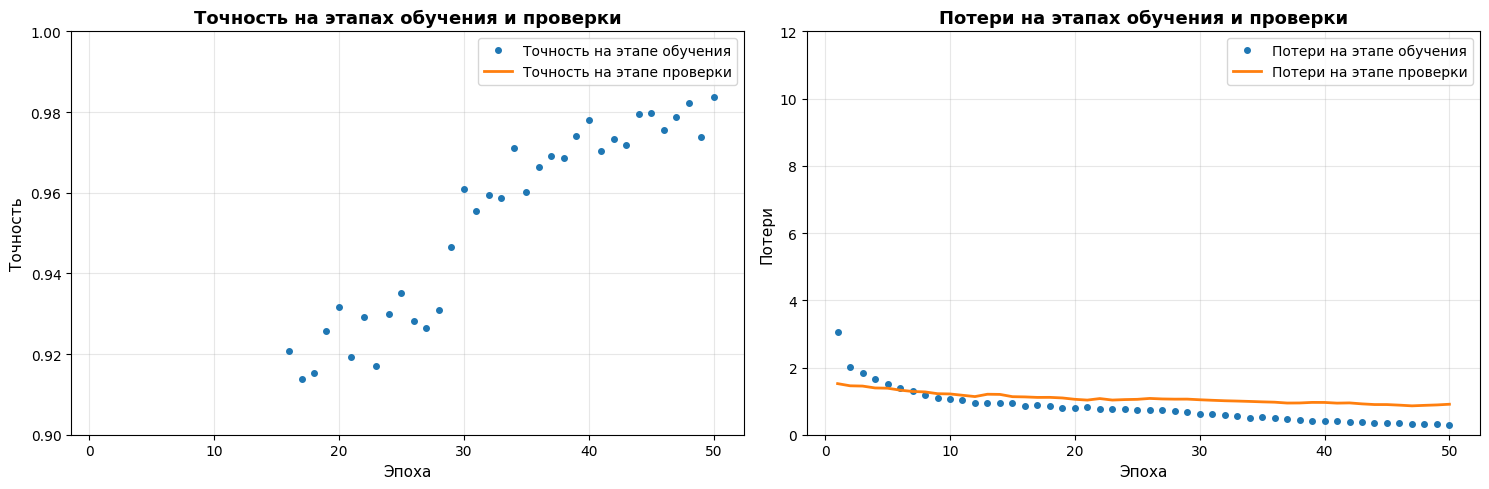


Финальные метрики:
Train Accuracy: 0.9838 (98.38%)
Validation Accuracy: 0.8651 (86.51%)
Train Loss: 0.2929
Validation Loss: 0.9070


In [ ]:
# Построение графиков (в стиле лекций)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history_features.history['accuracy']) + 1)

# График точности
axes[0].plot(epochs_range, history_features.history['accuracy'], 'o',
             label='Точность на этапе обучения', markersize=4)
axes[0].plot(epochs_range, history_features.history['val_accuracy'], '-',
             label='Точность на этапе проверки', linewidth=2)
axes[0].set_title('Точность на этапах обучения и проверки', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Эпоха', fontsize=11)
axes[0].set_ylabel('Точность', fontsize=11)
axes[0].set_ylim([0.9, 1.0])
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# График потерь
axes[1].plot(epochs_range, history_features.history['loss'], 'o',
             label='Потери на этапе обучения', markersize=4)
axes[1].plot(epochs_range, history_features.history['val_loss'], '-',
             label='Потери на этапе проверки', linewidth=2)
axes[1].set_title('Потери на этапах обучения и проверки', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Эпоха', fontsize=11)
axes[1].set_ylabel('Потери', fontsize=11)
axes[1].set_ylim([0, 12])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Финальные метрики
final_train_acc = history_features.history['accuracy'][-1]
final_val_acc = history_features.history['val_accuracy'][-1]
final_train_loss = history_features.history['loss'][-1]
final_val_loss = history_features.history['val_loss'][-1]

print(f'\nФинальные метрики:')
print(f'Train Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)')
print(f'Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)')
print(f'Train Loss: {final_train_loss:.4f}')
print(f'Validation Loss: {final_val_loss:.4f}')


In [ ]:
# Оценка на тестовой выборке
test_loss_features, test_accuracy_features = model_features.evaluate(
    test_features_flat, test_labels, verbose=0
)

print(f'РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (Feature Extraction):')
print(f'Test Accuracy: {test_accuracy_features:.4f} ({test_accuracy_features*100:.2f}%)')
print(f'Test Loss: {test_loss_features:.4f}')

РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (Feature Extraction):
Test Accuracy: 0.8792 (87.92%)
Test Loss: 0.7374


In [ ]:
# Сохранение модели
model_features.save('model_efficientnetb1_features.keras')
print('Модель сохранена: model_efficientnetb1_features.keras')

# Опционально: сохранение признаков на диск
np.save('train_features.npy', train_features_flat)
np.save('val_features.npy', val_features_flat)
np.save('test_features.npy', test_features_flat)
np.save('train_labels.npy', train_labels)
np.save('val_labels.npy', val_labels)
np.save('test_labels.npy', test_labels)


✓ Модель сохранена: model_efficientnetb1_features.keras
✓ Признаки сохранены в .npy файлы


28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 678ms/step - accuracy: 0.6950 - loss: 0.9470
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8811 - loss: 0.7478

Результаты на тестовой выборке:
CNN: Test Accuracy = 0.7089, Test Loss = 0.9292
EfficientNetB1: Test Accuracy = 0.8792, Test Loss = 0.7374


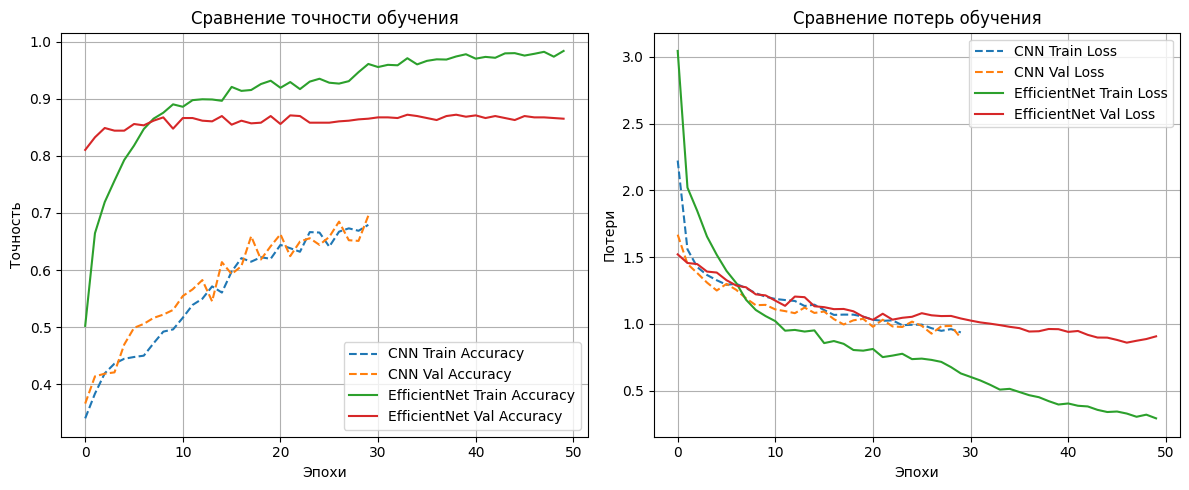

In [ ]:
model_cnn = keras.models.load_model('model_cnn_custom.keras')
model_efficientnet = keras.models.load_model('model_efficientnetb1_features.keras')

# Оценка CNN на тестовой выборке
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(test_dataset)

# Оценка EfficientNet на тестовой выборке
test_loss_efficientnet, test_accuracy_efficientnet = model_efficientnet.evaluate(test_features_flat, test_labels)

print(f"\nРезультаты на тестовой выборке:")
print(f"CNN: Test Accuracy = {test_accuracy_cnn:.4f}, Test Loss = {test_loss_cnn:.4f}")
print(f"EfficientNetB1: Test Accuracy = {test_accuracy_efficientnet:.4f}, Test Loss = {test_loss_efficientnet:.4f}")
# Графики точности
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='CNN Train Accuracy', linestyle='--')
plt.plot(history.history['val_accuracy'], label='CNN Val Accuracy', linestyle='--')
plt.plot(history_features.history['accuracy'], label='EfficientNet Train Accuracy')
plt.plot(history_features.history['val_accuracy'], label='EfficientNet Val Accuracy')
plt.title('Сравнение точности обучения')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

# Графики потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='CNN Train Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='CNN Val Loss', linestyle='--')
plt.plot(history_features.history['loss'], label='EfficientNet Train Loss')
plt.plot(history_features.history['val_loss'], label='EfficientNet Val Loss')
plt.title('Сравнение потерь обучения')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
